# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number : 25

## Student 1 
### Name : Aditya Kunar
### ID :

## Student 2
### Name : Anwesh Marwade
### ID : 5052068

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [70]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets
from nltk import ngrams
import time
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from numpy.linalg import norm
from sklearn import preprocessing
import mmh3
import math

%config InlineBackend.figure_format = 'retina'

## Read the Botnet Data

In [5]:
#Loading in all scenarios.
data0 = pd.read_csv("capture20110817.binetflow")
data1 = pd.read_csv("capture20110818.binetflow")
data2 = pd.read_csv("capture20110819.binetflow")
data3 = pd.read_csv("capture20110818-2.binetflow")
dataMerged =pd.concat([data0,data1,data2,data3])

## 1. Familiarization and discretization task – 1 A4

### Discretize selected features

In [14]:
data = data1.copy()
Labels = [] 
for i in data.Label.values:
    if re.search("Background",i)!=None:
        Labels.append(-1)
    elif re.search("Normal",i)!=None:
        Labels.append(0)
    elif re.search("Botnet",i)!=None:
        Labels.append(1)
data["Label"]=Labels
data.Label.unique() 

#Creating new dataframe by removing background netflow data.
data_WB = data.loc[data["Label"]!=-1]
#Just run this twice to kill the annoying warning. Converting StartTime to a datetime variable. 
data_WB.loc[:,"StartTime"] = pd.to_datetime(data_WB["StartTime"])
for col in data_WB.columns:
    if(data_WB[col].isna().sum()):
        print('col_name: '+ col)
        print('count NAs: %d' %data_WB[col].isna().sum())

col_name: Sport
count NAs: 27
col_name: Dport
count NAs: 101196
col_name: State
count NAs: 1227
col_name: sTos
count NAs: 29
col_name: dTos
count NAs: 107104


In [18]:
#We see that sTos and dTos are NOT adding meaningful information. Better to get rid of it. 
data_WB.sTos.unique(),data_WB.dTos.unique()
#Due to large number of missing values, drop dTos and Dport as it will only cloud results. Removing sTos as it's useless.
data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])

# For the label encoding, replacing nans with default values for State and Sport and converting them to categorical. 
data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
data_vis=data_WB_cleaned.copy()


In [19]:
#Converting categorical variables in numerical ones using label encoder to be used for correlation. 

le = preprocessing.LabelEncoder()
categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
for i in categorical_columns:
    data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
data_M = data_WB_cleaned.loc[data_WB_cleaned["Label"]==1] # This stores data on malicious netflows.
data_NM = data_WB_cleaned.loc[data_WB_cleaned["Label"]==0]# This stores data on normal netflows. 

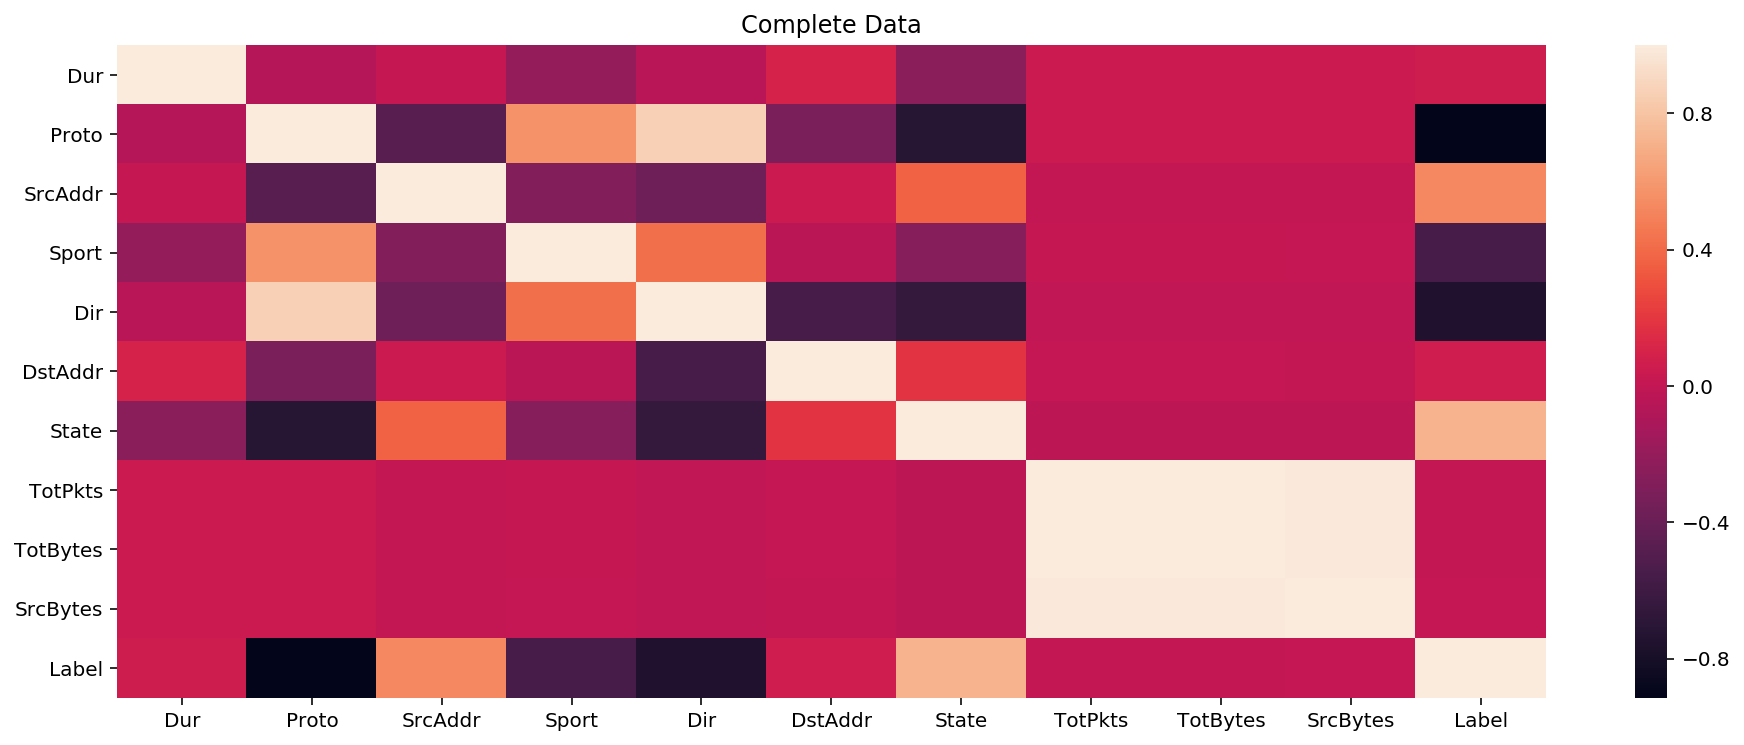

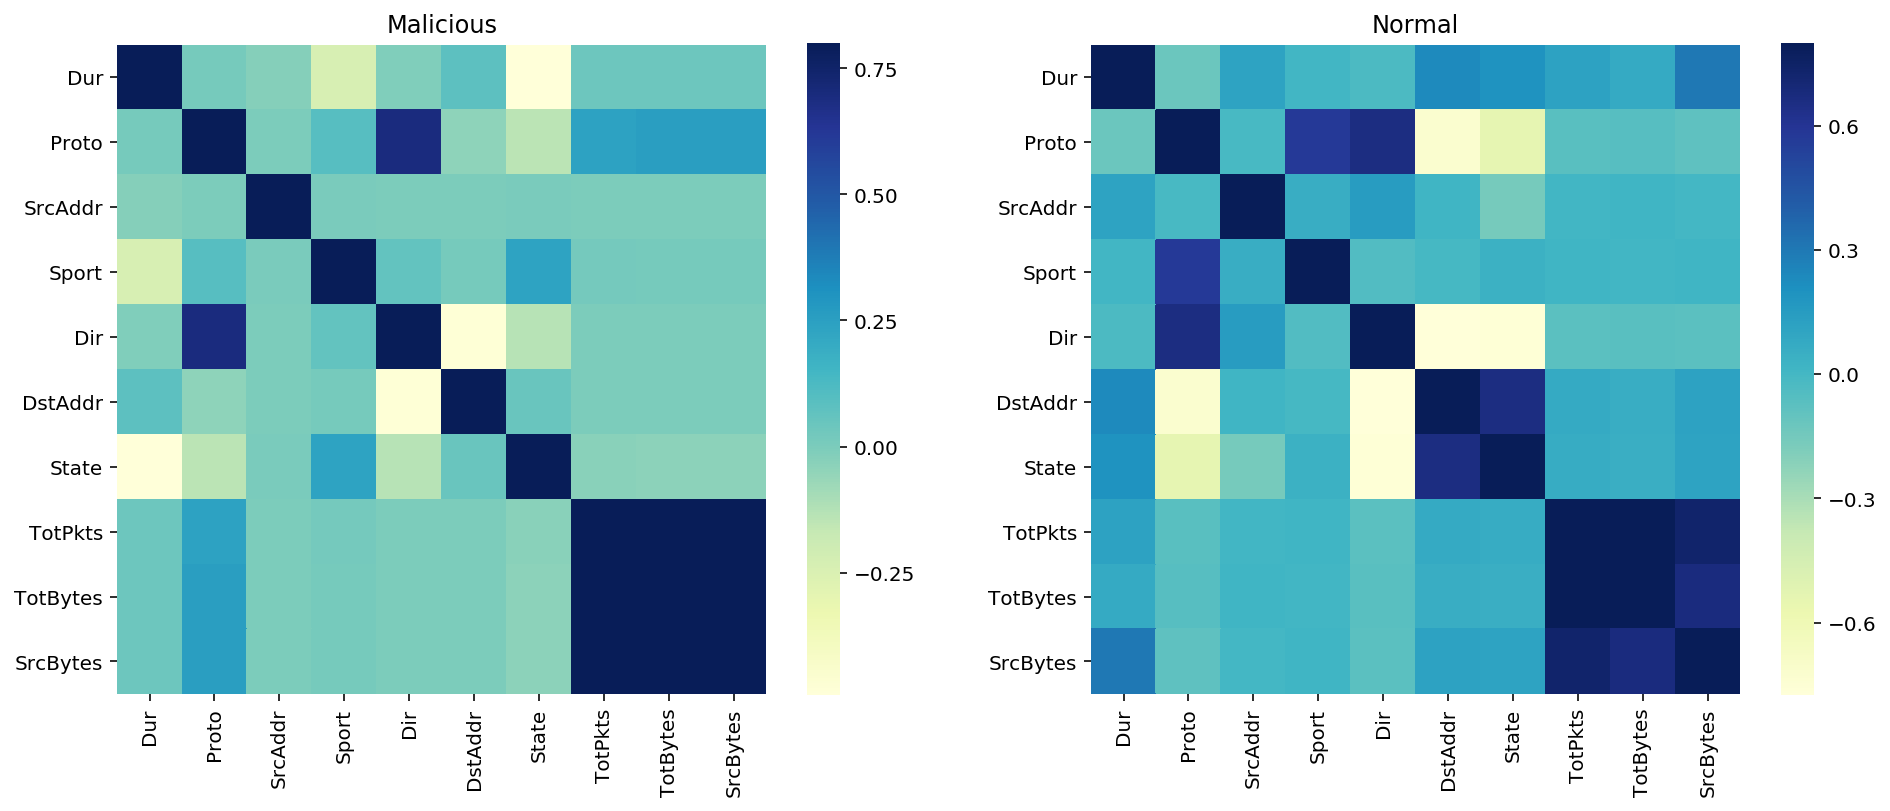

In [21]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 6))
sns.heatmap(data_WB_cleaned.corr())
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 6))

sns.heatmap(data_M.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(data_NM.drop(['Label'], axis=1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

In [22]:
data_WB_cleaned.corr()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,1.000000,-0.059651,0.019821,-0.202402,-0.045376,0.101189,-0.253972,0.040007,0.041698,0.039328,0.050622
Proto,-0.059651,1.000000,-0.480068,0.570802,0.860547,-0.318632,-0.712716,0.041047,0.042357,0.039165,-0.914309
SrcAddr,0.019821,-0.480068,1.000000,-0.284142,-0.369949,0.036393,0.369286,-0.000524,0.000155,0.003175,0.523478
Sport,-0.202402,0.570802,-0.284142,1.000000,0.417685,-0.033035,-0.269878,0.014761,0.013651,0.009765,-0.553765
Dir,-0.045376,0.860547,-0.369949,0.417685,1.000000,-0.549063,-0.650457,-0.004379,-0.005671,-0.005320,-0.754101
DstAddr,0.101189,-0.318632,0.036393,-0.033035,-0.549063,1.000000,0.179736,0.008281,0.007701,0.000994,0.062006
State,-0.253972,-0.712716,0.369286,-0.269878,-0.650457,0.179736,1.000000,-0.020216,-0.021621,-0.018281,0.718407
TotPkts,0.040007,0.041047,-0.000524,0.014761,-0.004379,0.008281,-0.020216,1.000000,0.998092,0.992488,-0.001117
TotBytes,0.041698,0.042357,0.000155,0.013651,-0.005671,0.007701,-0.021621,0.998092,1.000000,0.991953,-0.000018
SrcBytes,0.039328,0.039165,0.003175,0.009765,-0.005320,0.000994,-0.018281,0.992488,0.991953,1.000000,0.006605


#### Through the correlation plot we determine the most important features in determining whether a data point is malicious or not based on whether they have the high correlation with the label: `Proto`, `Dir`, `State`


In [23]:
data_WB_cleaned.Proto.unique(),data_WB_cleaned.Dir.unique(),data_WB_cleaned.State.unique()

(array([2, 3, 0, 1]),
 array([4, 3, 0, 5, 1, 2]),
 array([ 57,  12,   4,  27,  54,  14,  59,  32,  91,  20,  13,  72,  34,
         96,  42,  75,  39,  40,  31,  90,  81,  93,  19,  25,  22,  95,
         33, 115,  71,  89,  36,  86,  51, 103,  44, 101,  67,  50,  74,
          8,   7,  73,  43,  68,  83,  82,  52,   0,  46,   6,  47, 118,
          5,  41,  94,  63,  45, 100, 102,  62, 104,  49,  48, 114, 111,
        116, 113, 110, 105, 112, 117,  80,  99,  60, 109, 108,  61,  35,
         55,   3,  56,  64,  70,  65,  29,  10,  97,  53,  85,  11,  21,
         76,  84,   1,  77,  66,  15,  78,   9,  24,  18,  92,  17,  79,
         98,  37,  26,  28,  69, 107,  23,  87,  58,  30,  88, 119,  38,
        106,   2,  16]))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


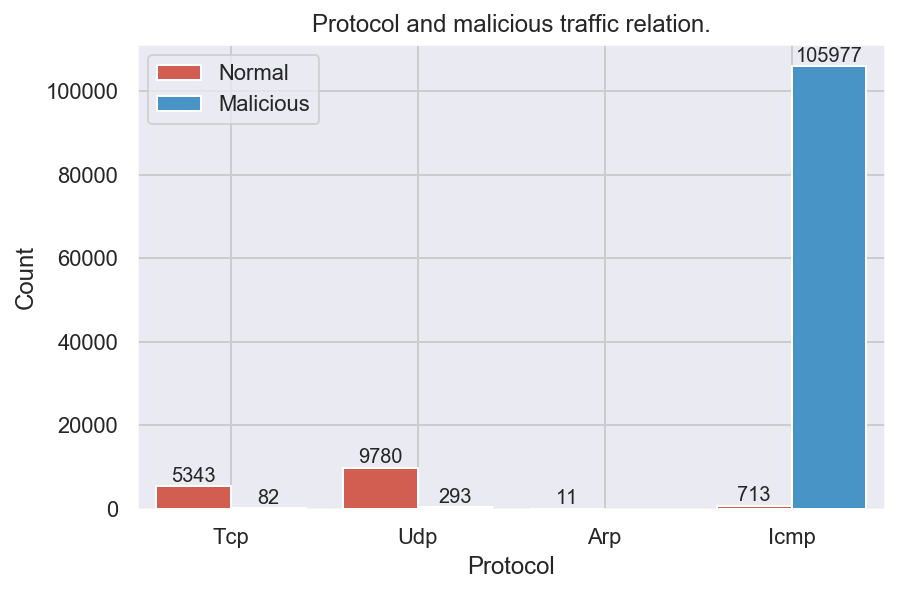

In [25]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Proto", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.set(xticklabels=["Tcp","Udp","Arp","Icmp"])
ax.legend(["Normal","Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


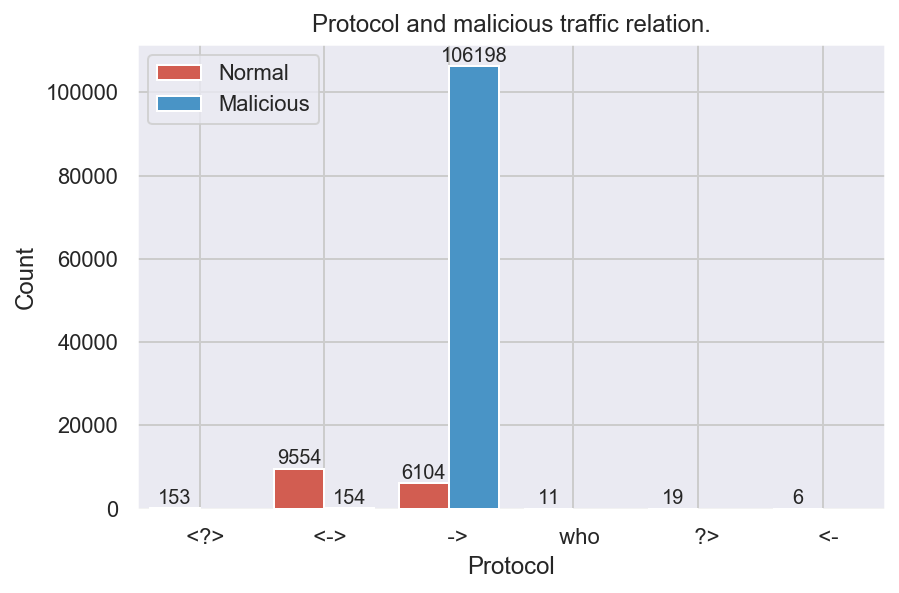

In [27]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Dir", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Malicious"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1d}'.format(height.astype(int)),
            ha="center",size=10)

From the below visualisation we can see "Proto" and "Dir" which is already discrete due it being categorical has a major influence on the chance of making a certain record in the netflow data malicious. "State" feature is also very important but the visualisation is not useful due to too many categories. Now returning to the heatmaps of the malicious and normal datasets and observing the correlations for "Proto" and "State" with the other variables, we see that "Proto" has a higher correlation with the "TotBytes" in the malicious dataset than the normal dataset which means, "TotBytes" has a different behaviour for malicious netflows. Similarly, we see the "State" feature has very different correlations with the "Dur" feature between the malicious and normal datasets. With this premise, I believe discretizing the "TotBytes" and "Dur" are going to useful for studying an infected host. 

In [28]:
#Selecting a certain infected host.
data_infected_host = data_M.loc[data_M["SrcAddr"]==12]

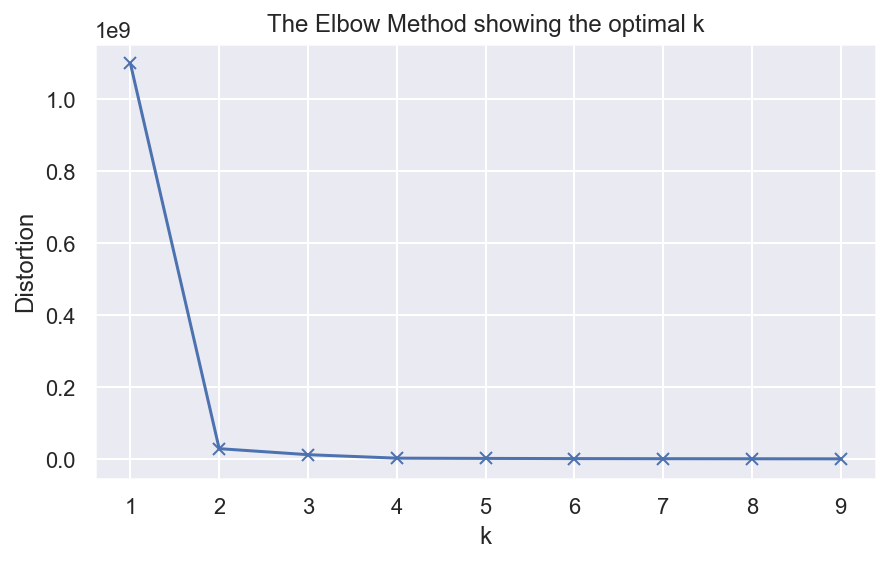

In [31]:
#Distortions for DUR.
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["Dur"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

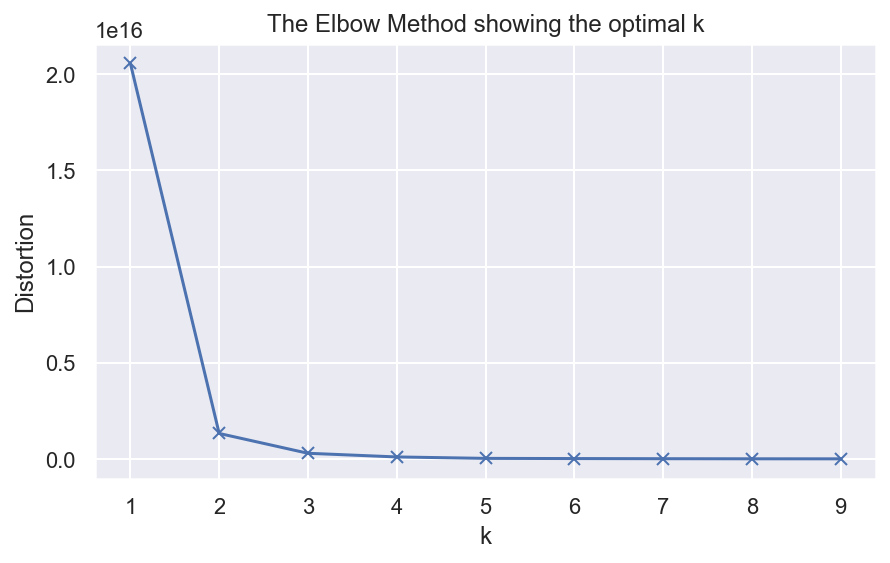

In [33]:
#Distortions for TotBytes
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["TotBytes"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

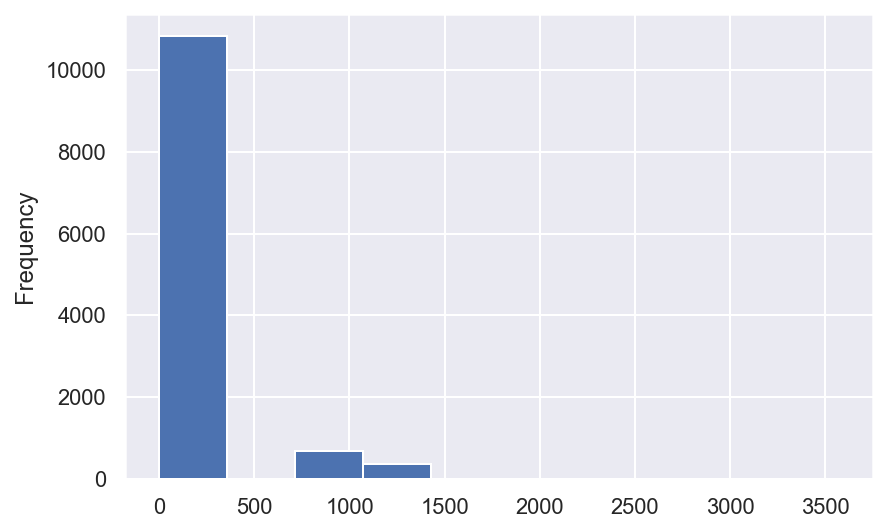

In [34]:
ax=data_infected_host["Dur"].plot(kind="hist")

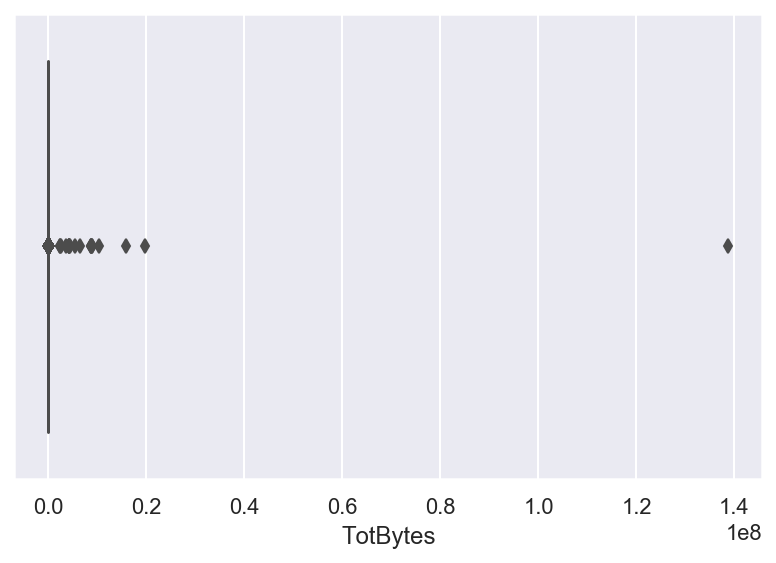

In [35]:
ax=sns.boxplot(data_infected_host["TotBytes"])

There seems to be a great deal of outliers in both features, therefore I must make then a bit more continous by removing outliers to discretize them better. 

In [36]:
#This range isn't right. 
data_infected_host["TotBytes"].min(),data_infected_host["TotBytes"].max()

(60, 138720832)

In [ ]:
#last 20 values are very large. 
TotBytes_Pure = TotBytes[:-20]
# Getting the outliers to see what they look like for the reviewer.
TotBytes_Outliers=TotBytes[-20:]

#Therefore we have 2 valid intervals based on quantile based discretization and the 3rd will be for the outliers. 
pd.qcut(TotBytes_Pure, q=2)

#Lets discretize the feature TotBytes now. Run this twice to remove the warning. 
data_infected_host.loc[(data_infected_host['TotBytes']>59.99) &(data_infected_host['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_infected_host.loc[(data_infected_host['TotBytes']>1066) &(data_infected_host['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_infected_host.loc[(data_infected_host['TotBytes']>55432),'New_TotBytes'] = 'Level_3'

In [ ]:
data_infected_host["New_TotBytes"].unique()
ax=sns.barplot(data_infected_host["New_TotBytes"].value_counts().index,data_infected_host["New_TotBytes"].value_counts().values)
ax.set_title("Barplot to show counts for each level for TotBytes feature.")
plt.show()

In [37]:
# Now doing the same for "Dur" feature. This range doesn't look right. 
data_infected_host["Dur"].min(),data_infected_host["Dur"].max()

(0.0, 3570.946045)

In [39]:
data_infected_host.groupby(["Dur"]).count()

,StartTime,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,,,,,,,,,,,
0.000000,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793,10793
0.000227,1,1,1,1,1,1,1,1,1,1,1
0.000233,1,1,1,1,1,1,1,1,1,1,1
0.000263,1,1,1,1,1,1,1,1,1,1,1
0.000345,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1274.888062,1,1,1,1,1,1,1,1,1,1,1
1274.926147,1,1,1,1,1,1,1,1,1,1,1
1693.866089,1,1,1,1,1,1,1,1,1,1,1


Problem is we cannot get well defined quantiles for such a discontinous array of values. As pd.qcut(Dur,2) This doesn't work. But based on my sorted list and the intuition of clustering based on the values of the data points into 3 groups which was shown before using the elbow method. This is what I did. 


1) 0.0 - .17711 (the first group is reserved for data points that are 0 or close to it. I believe this is one valid cluster of values.)

2) 2.81- 367.652 (the second group comprises of the rest of the data that lies within 367. Similarly these also would be clustered together.)

3) 786.85-3570.946045.3  (I believe these numbers are very large compared to the normal values seen thus far which are closer to zero and represent the outliers. Same as before)  


It should be noted that the Kmeans graph on this feature mainly highlighted the use of 2 bins and it is ofcourse obvious that these are clusters with values that range from 0.0-367.652 and 786.85-3570.94. respectively. I've used 3 bins because I wanted more bins for my combined feature. 


I hope this sufficiently justifies my choice of bins.

In [40]:
#Lets discretize the feature Dur now.
data_infected_host.loc[(data_infected_host['Dur']>=0.0) &(data_infected_host['Dur']<2.81) ,'New_Dur'] = 'Level_1'
data_infected_host.loc[(data_infected_host['Dur']>2.81) &(data_infected_host['Dur']<786.85) ,'New_Dur'] = 'Level_2'
data_infected_host.loc[(data_infected_host['Dur']>786.85) &(data_infected_host['Dur']<3571.94) ,'New_Dur'] = 'Level_3'
data_infected_host["New_Dur"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

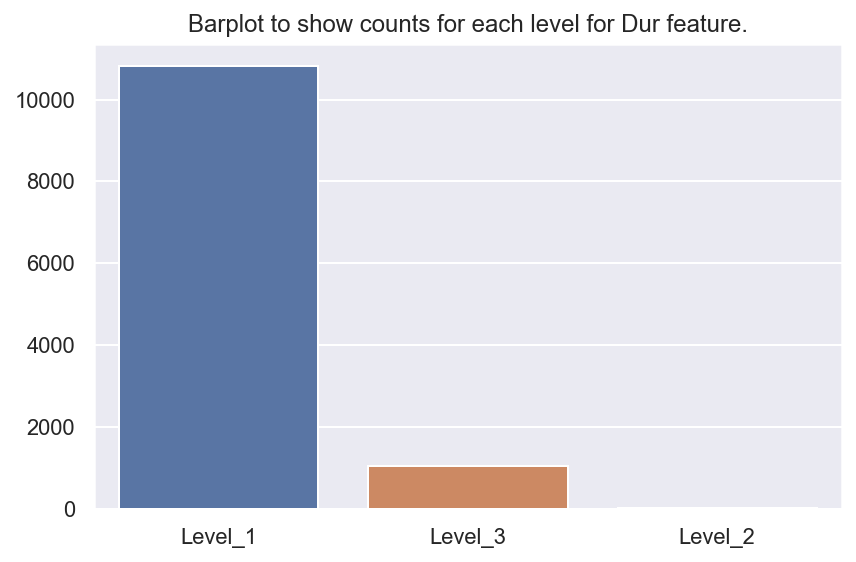

In [41]:
ax=sns.barplot(data_infected_host["New_Dur"].value_counts().index,data_infected_host["New_Dur"].value_counts().values)
ax.set_title("Barplot to show counts for each level for Dur feature.")
plt.show()

Based on this discritization and the barplots of the different levels of the individual features we see that values majorly in the range of level_1 for both "Dur"(0.0-2.81 seconds) and "TotBytes"(66-1066 bytes).

To combine features, we take the cartesian product of the three levels for each of the two features, giving us 9 possibilites as follows:


| Dur           | TotBytes      | Combined_Feature |
| ------------- |:-------------:| :---------------:|
| Level_1       |  Level_1      | Combined_Level_1 |
| Level_1       |  Level_2      | Combined_Level_2 |
| Level_1       |  Level_3      | Combined_Level_3 |
| Level_2       |  Level_1      | Combined_Level_4 | 
| Level_2       |  Level_2      | Combined_Level_5 |   
| Level_2       |  Level_3      | Combined_Level_6 | 
| Level_3       |  Level_1      | Combined_Level_7 |
| Level_3       |  Level_2      | Combined_Level_8 |
| Level_3       |  Level_3      | Combined_Level_9 | 

Based on our logic, we write a dicretizer function that will be used for discretiztion (w/o background noise) henceforth.

In [110]:
def data_discretizer(data, t = 'default'):        
    #Fixing the labels to appropriate values. Background->-1, Normal->0, Malicious->,1.
    data=data.copy()
    Labels = [] 
    for i in data.Label.values:
        if re.search("Background",i)!=None:
            Labels.append(-1)
        elif re.search("Normal",i)!=None:
            Labels.append(0)
        elif re.search("Botnet",i)!=None:
            Labels.append(1)
    data["Label"]=Labels
    data.Label.unique()
    #Creating new dataframe by removing background netflow data.
    data_WB = data.loc[data["Label"]!=-1]
    #Due to large number of missing values, removing dTos and Dport as it will only cloud results. 
#     Removing sTos as it's useless.
    data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])
    # For the label encoding, replacing nans with default values for State and Sport and 
#     converting them to categorical. 
    data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
    data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
    data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
    data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
    #Converting categorical variables in numerical ones using label encoder to be used for correlation. 
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
    for i in categorical_columns:
        data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])
    Binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
    data_discrete = Binner.fit_transform(data_WB_cleaned.loc[:,["Dur","TotBytes"]])
    data_discrete = pd.DataFrame(data_discrete,columns=["New_Dur","New_TotBytes"])
    data_discrete["Labels"]= data_WB_cleaned.Label.values
    data_discrete["SrcAddr"]= data_WB_cleaned.SrcAddr.values
    combined_levels=[]
    for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
        if (i==0) & (j==0):
            combined_levels.append("Combined_Level_1")
        elif (i==0) & (j==1):
            combined_levels.append("Combined_Level_2")
        elif (i==0) & (j==2):
            combined_levels.append("Combined_Level_3")
        elif (i==1) & (j==0):
            combined_levels.append("Combined_Level_4")
        elif (i==1) & (j==1):
            combined_levels.append("Combined_Level_5")
        elif (i==1) & (j==2):
            combined_levels.append("Combined_Level_6")
        elif (i==2) & (j==0):
            combined_levels.append("Combined_Level_7")
        elif (i==2) & (j==1):
            combined_levels.append("Combined_Level_8")
        elif (i==2) & (j==2):
            combined_levels.append("Combined_Level_9")
    data_discrete.loc[:,"Combined_Levels"]=combined_levels

    return data_discrete

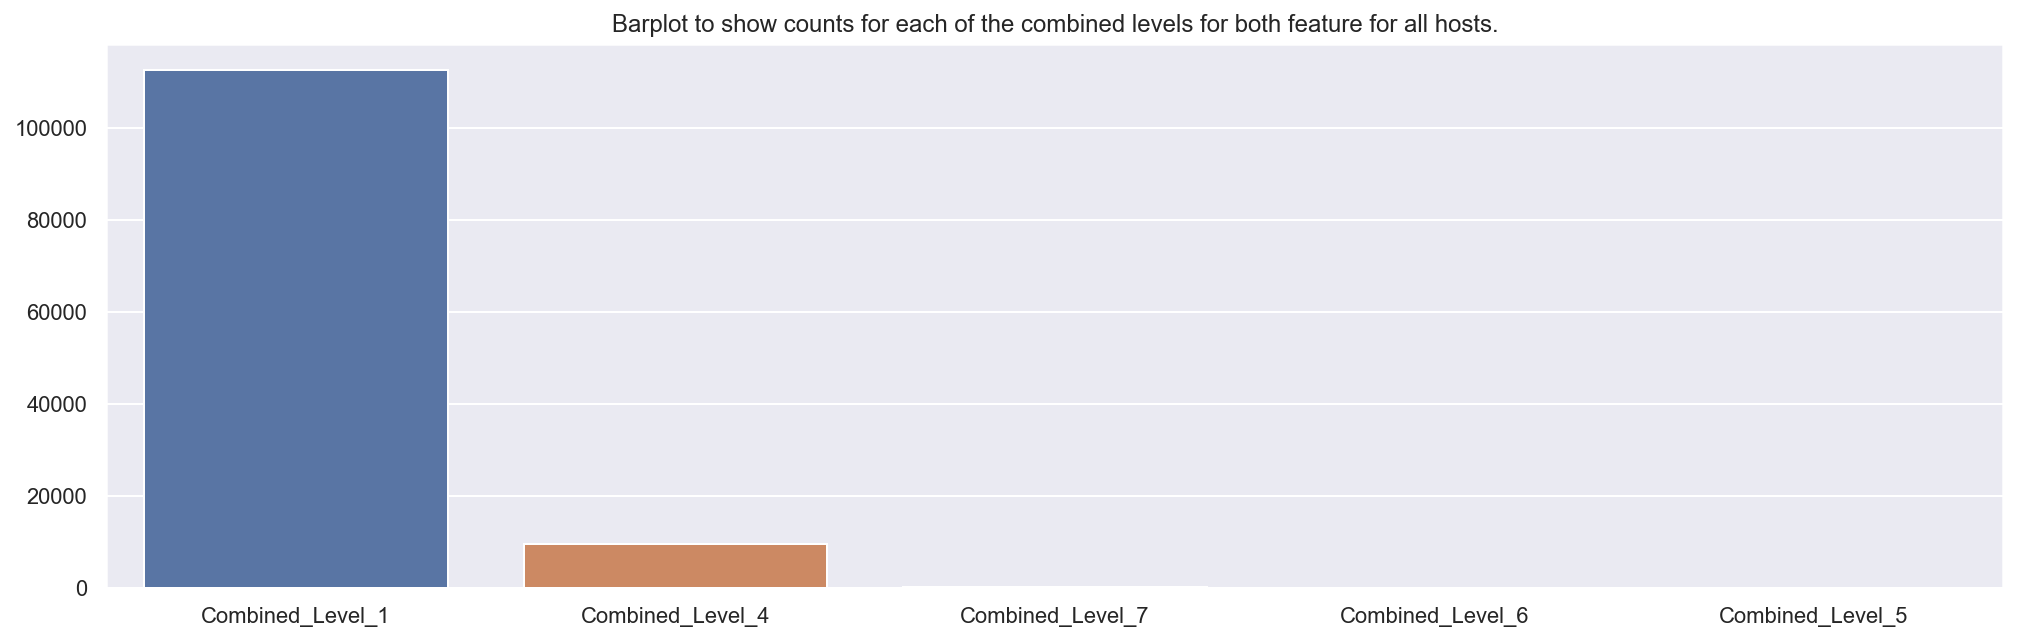

In [111]:
data1_discrete = data_discretizer(data1)
fig,ax= plt.subplots(figsize=(17,5))
ax=sns.barplot(data1_discrete["Combined_Levels"].value_counts().index,data1_discrete["Combined_Levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature for all hosts.")
plt.show()

## 2. Frequent task – Aditya Kunar

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

NameError: name 'Binner' is not defined

## 3. Sketching task – Anwesh Marwade

### 3a. COUNT-MIN sketch


In [50]:
# Scenario 10
data_discrete = data_discretizer(data1)
discretized = data_discrete.Combined_Levels.values

# Creating the different n-grams.
n = 3
threegrams = ngrams(discretized, n)

# Creating a dictionary that stores the counts for the different ngrams. 
gram_freq={}
stream_grams = []
for i in threegrams:
    s = []
    for gram in i:
        s.append(re.findall("\d+",gram)[0])
    
    g = ''.join(s)
    stream_grams.append(g)
    gram_freq[g] = gram_freq.get(g, 0) + 1

# Sorting the ngram_freq dictionary for return top 10 occuring n-grams.
gram_freq={k: v for k, v in sorted(gram_freq.items(), key=lambda item: -1*item[1])} 

# Returning top 10 as demanded in the task.
top10 = {k: gram_freq[k] for k in list(gram_freq)[:10]}
top10_ngrams = list(top10.values())

In [51]:
# Count min sketch


class Countminsketch:
    def __init__(self, w, num_hash):
        ''' 
        Method to init the data structure
        width (int): Width of the sketch table or number of posible hash values
        num_hash (int): Depth of the sketch table (also =number of hash functions)
        '''
        self.width = w
        self.num_hash = num_hash
        self.table = np.zeros([num_hash, w])  # Creating an empty table
        self.seed = np.random.randint(w, size = num_hash) 

    def increment(self, key):
        ''' 
        Method to increment count of the string under consideration.
        '''
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            
            self.table[i, index] = self.table[i, index]+1
            
    def estimate_freq(self, key):
        ''' 
        Method to estimate the frequency of the key (string that is passed as argument)
        '''
        min_arr = []
        for i in range(0, self.num_hash):
            index = mmh3.hash(key, self.seed[i]) % self.width
            min_arr.append(self.table[i, index])
            
        return min(min_arr)
    
    def show_table(self):
        return self.table
    
def CMS_wrapper_top_10(w, d, data):
    cms = Countminsketch(w, d)
    for i in stream_grams:
        cms.increment(i)
    countmin_dict = {}
    for gram in set(stream_grams):
        countmin_dict[gram] = int(cms.estimate_freq(gram))
    top10 = {k: v for k, v in sorted(countmin_dict.items(), key=lambda item: -1*item[1])}
    return list(top10.values())[:10]

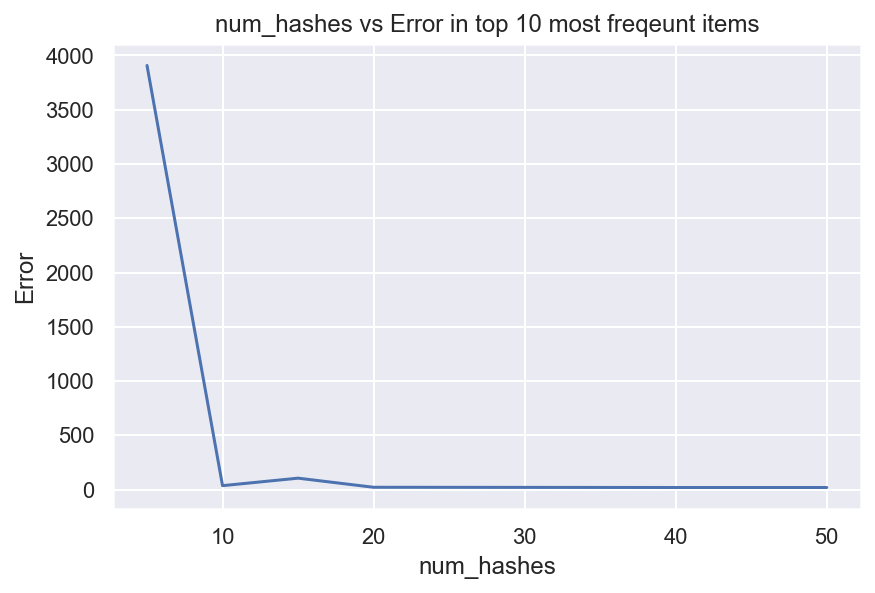

In [68]:
# top10_cms = CMS_wrapper_top_10(10, 15, stream_grams)
# top10_cms
hashes = [1, 5, 10, 15, 20, 40, 50]
error = np.zeros(len(hashes))
for idx, j in enumerate(hashes):
    top10_cms = CMS_wrapper_top_10(10, j, stream_grams)
    error[idx] = (sum([a_i - b_i for a_i, b_i in zip(top10_cms, top10_ngrams)]))
    
ax=sns.lineplot(x=hashes[1:],y=error[1:])
ax.set_title("num_hashes vs Error in top 10 most freqeunt items")
ax.set_xlabel("num_hashes")
ax.set_ylabel("Error")
plt.show()

### 3b. Analysis and answers to the questions

## LSH-Task: Common functions

In [69]:
# data_discrete needs to be different for this .... we'll talk on call 
data_discrete = data_discretizer(data1, "full")
src=data_discrete["SrcAddr"].values
dst=data_discrete["DstAddr"].values
ip_pairs=[]
for i,j in zip(src,dst):
    ip_pairs.append((i,j))
unique_pairs=list(set(ip_pairs)) 

#Getting the combined_features for each IP-pair and creating n-grams. 
datasubsets=[]
for i in set(unique_pairs):
    datasubsets.append(data_discrete.loc[(data_discrete["SrcAddr"]==i[0])&(data_discrete["DstAddr"]==i[1])])

Combined_pairF=[]
for i in datasubsets:
    Combined_pairF.append(i["Combined_levels"].values)    

Ngram_combined_pairF=[]

for i in Combined_pairF:
    threegrams = ngrams(i, 3)
    Ngram_combined_pairF.append(threegrams)     
    
# pairwise_ngrams n-grams frequncy for each ip-pair.     
pairwise_ngrams=[]
for i in Ngram_combined_pairF:
    pairwise_ngram={}
    for j in i:
        s = "-"
        s = s.join(j)
        pairwise_ngram[s] = pairwise_ngram.get(s, 0) + 1
    
    pairwise_ngrams.append(pairwise_ngram) 

    #Removing the empty ip_pairs.
index=[]
for i in enumerate(pairwise_ngrams):
    if len(list(i[1].keys()))!=0:
        index.append(i[0]) 
pairwise_ngrams_pure = [i[1] for i in enumerate(list(pairwise_ngrams)) if i[0] in index]        
pairwise_ngrams=pairwise_ngrams_pure

KeyError: 'DstAddr'

## 4. Min-wise locality sensitive hashing task – Aditya Kunar

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task- Anwesh Marwade

### 5a. Implementation - locality sensitive hashing

In [ ]:
def lsh_hyperplanes(data, num_planes):
    r = np.zeros((num_planes, len(data[0])))
    for i in range(num_planes):
        r[i] = np.random.randn(len(data[0]))

    # for idx in range(len(df.values)):
    prod = np.zeros((len(data), num_planes))
    prod = np.dot(data, r.T)
    prod = np.where(prod > 0, 1, 0)
    hash_bins = []
    for i in range(len(prod)):
        hash_bins.append(''.join(str(x) for x in prod[i]))
    return hash_bins

In [ ]:
# df.drop(['hash_bins'], axis=1, inplace=True)
hash_bins = lsh_hyperplanes(df.values, num_planes = 3)
df['hash_bins'] = pd.DataFrame(hash_bins)

In [ ]:
# import math
def euclideanDistance(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance = distance + (row1[i] - row2[i])**2
    return math.sqrt(distance)
df.hash_bins.unique()

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances
df_copy = df.drop(['hash_bins'], axis=1)
t1=time.perf_counter()
# euc_dist = euclidean_distances(df.drop(['hash_bins'], axis=1).values, df.drop(['hash_bins'], axis=1).values)
num_records = len(df_copy)
euc_dist=np.zeros((num_records, num_records))
for i in range(num_records):
    for j in range(num_records):
            euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

In [ ]:
t1=time.perf_counter()
for hash_code in df.hash_bins.unique():
    df_copy = df[df['hash_bins'] == hash_code].drop(['hash_bins'], axis=1)
    num_records = len(df_copy)
    euc_dist=np.zeros((num_records, num_records))
    for i in range(num_records):
        for j in range(num_records):
                euc_dist[i][j] = euclideanDistance(df_copy.values[i], df_copy.values[j])
#     print(euc_dist)
t2=time.perf_counter()
print("Time to execute this was "+str(t2-t1)+" seconds.")

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

In [114]:
def Ngram_profile_generator(data_discrete):
    data = data_discrete.copy()
        #All source Ips.
    Srcs=set(data["SrcAddr"].values)
    # The malicious source IPs or hosts. 
    M_src=set(data.loc[data["Labels"]==1]["SrcAddr"].values)

    #Getting the combined_features for each source IP and creating n-grams. 
    datasubsets=[]
    for i in Srcs:
        datasubsets.append(data.loc[(data["SrcAddr"]==i)])

    # Discretized flow per source
    sequence_per_src=[]
    for i in datasubsets:
        sequence_per_src.append(i["Combined_Levels"].values)

    ngrams_per_src = []

    for i in sequence_per_src:
        threegrams = ngrams(i, 3)
        ngrams_per_src.append(threegrams)

    ngrams_profile_per_src=[]
    for i in ngrams_per_src:
        ngram_map={}
        for j in i:
            s = "-"
            s = s.join(j)
            ngram_map[s] = ngram_map.get(s, 0) + 1

        ngrams_profile_per_src.append(ngram_map)

    # To remove an blanks in case they occur
    index=[]
    for i in enumerate(ngrams_profile_per_src):
        if len(list(i[1].keys()))!=0:
            index.append(i[0])
    ngrams_profile_per_src_pure = [i[1] for i in enumerate(list(ngrams_profile_per_src)) if i[0] in index]        
    ngrams_profile_per_src=ngrams_profile_per_src_pure

    ind=list(set(Srcs)-(set(Srcs)-set(index)))

    unique_ngrams_list=[]
    for i in ngrams_profile_per_src:
        for j in list(i.keys()):
            unique_ngrams_list.append(j)
    unique_ngrams_list = set(unique_ngrams_list)

    df = pd.DataFrame(np.zeros((len(ngrams_profile_per_src),len(unique_ngrams_list))), columns=unique_ngrams_list)

    for idx, k in enumerate(ngrams_profile_per_src):
        for i in df.columns:
            if i in list(k.keys()):
                df.loc[idx, i]=k[i]

    df=df.set_index(pd.Series(list(ind))) 
    M_df=df.loc[M_src,:]
    N_df= df.loc[list(set(ind)-set(M_src))]

    return df,M_df,N_df

### 6a. Learn a sequential model

In [115]:
def cosine_sim(a, b):
    return np.dot(a, b)/(norm(a)*norm(b))

def predict_malicious_profiles(data):
    df,M_df,N_df = Ngram_profile_generator(data)
    true_infections = list(M_df.index)
    for infections in true_infections:

        remaining_infections = [i for i in true_infections if i != infections]
        infected_host = df.loc[df.index == infections].values
        test_hosts = df.loc[df.index != infections]
        cosine_arr = []

        predicted_infections = []
        for row in test_hosts.iterrows():
            cosine_arr.append(cosine_sim(infected_host, row[1].values))
            if cosine_sim(infected_host, row[1].values) > 0:
                predicted_infections.append(row[0])
        TP = len(set(predicted_infections).intersection(remaining_infections))

        FP = len(set(predicted_infections)-set(remaining_infections))

        print("Total predictions: %d, True Positives: %d, False Positives: %d" %(len(predicted_infections), TP, FP))
        break


In [116]:
# # df,M_df,N_df = Ngram_profile_generator(data1_discrete)
print("-------Prediction for Netflow 9-------")
data0_discrete = data_discretizer(data0)
predict_malicious_profiles(data0_discrete)
print("\n-------Prediction for Netflow 10-------")
data1_discrete = data_discretizer(data1)
predict_malicious_profiles(data1_discrete)
print("\n-------Prediction for Netflow 11-------")
data2_discrete = data_discretizer(data2)
predict_malicious_profiles(data2_discrete)
print("\n-------Prediction for Netflow 12-------")
data3_discrete = data_discretizer(data3)
predict_malicious_profiles(data3_discrete)

-------Prediction for Netflow 9-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 10-------
Total predictions: 16, True Positives: 9, False Positives: 7

-------Prediction for Netflow 11-------
Total predictions: 13, True Positives: 8, False Positives: 5

-------Prediction for Netflow 12-------
Total predictions: 5, True Positives: 2, False Positives: 3


## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


In [118]:
# Will be used for fingerprinting task and subsequent evaluation
data_discrete=data_discretizer(dataMerged)
data_discrete_train = data_discrete.sample(frac=0.5, replace=False, random_state=1)
data_discrete_eval = data_discrete.sample(frac=0.5, replace=False, random_state=1)

In [119]:
df,M_df,N_df = Ngram_profile_generator(data_discrete_train)
meansM= M_df.mean(axis=0)
meansN= N_df.mean(axis=0)
meanssM={}
for i,j in zip(meansM.index,meansM.values):
    meanssM[i]=j

meanssN={}
for i,j in zip(meansN.index,meansN.values):
    meanssN[i]=j

topNgramsM={k: v for k, v in sorted(meanssM.items(), key=lambda item: -1*item[1])}

# Print top 10 N grams in infected instances
dict(itertools.islice(topNgramsM.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 11222.916666666666,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 385.9166666666667,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 385.6666666666667,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 384.75,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 49.5,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 49.083333333333336,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 48.666666666666664,
 'Combined_Level_4-Combined_Level_1-Combined_Level_4': 13.75,
 'Combined_Level_1-Combined_Level_4-Combined_Level_4': 13.25,
 'Combined_Level_4-Combined_Level_4-Combined_Level_1': 13.083333333333334}

In [120]:
# Print top 10 N grams in Benign instances
topNgramsN={k: v for k, v in sorted(meanssN.items(), key=lambda item: -1*item[1])}
dict(itertools.islice(topNgramsN.items(), 10))

{'Combined_Level_1-Combined_Level_1-Combined_Level_1': 1707.375,
 'Combined_Level_1-Combined_Level_4-Combined_Level_1': 6.1875,
 'Combined_Level_4-Combined_Level_1-Combined_Level_1': 6.0625,
 'Combined_Level_1-Combined_Level_1-Combined_Level_4': 6.0625,
 'Combined_Level_1-Combined_Level_7-Combined_Level_1': 5.25,
 'Combined_Level_1-Combined_Level_1-Combined_Level_7': 5.25,
 'Combined_Level_7-Combined_Level_1-Combined_Level_1': 5.1875,
 'Combined_Level_7-Combined_Level_7-Combined_Level_7': 1.375,
 'Combined_Level_2-Combined_Level_1-Combined_Level_1': 0.25,
 'Combined_Level_1-Combined_Level_1-Combined_Level_2': 0.25}

In [121]:
notpresentinNormal=[]
for i in topNgramsN:
    if (topNgramsN[i]==0):
        notpresentinNormal.append(i)

# print set of flows not seen in benign traffic
notpresentinNormal

['Combined_Level_6-Combined_Level_1-Combined_Level_4',
 'Combined_Level_7-Combined_Level_4-Combined_Level_1',
 'Combined_Level_1-Combined_Level_6-Combined_Level_1',
 'Combined_Level_4-Combined_Level_7-Combined_Level_4',
 'Combined_Level_6-Combined_Level_1-Combined_Level_1',
 'Combined_Level_4-Combined_Level_4-Combined_Level_4',
 'Combined_Level_1-Combined_Level_4-Combined_Level_4',
 'Combined_Level_4-Combined_Level_7-Combined_Level_1',
 'Combined_Level_4-Combined_Level_4-Combined_Level_7',
 'Combined_Level_1-Combined_Level_1-Combined_Level_6',
 'Combined_Level_1-Combined_Level_4-Combined_Level_7']

In [122]:
for i in notpresentinNormal:
    print("Value counts for this ngram in malicious data:\n"+i)
    print(topNgramsM[i])

Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_7-Combined_Level_4-Combined_Level_1
1.1666666666666667
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_6-Combined_Level_1
0.5
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_4
0.08333333333333333
Value counts for this ngram in malicious data:
Combined_Level_6-Combined_Level_1-Combined_Level_1
0.4166666666666667
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_4
0.6666666666666666
Value counts for this ngram in malicious data:
Combined_Level_1-Combined_Level_4-Combined_Level_4
13.25
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_7-Combined_Level_1
1.0
Value counts for this ngram in malicious data:
Combined_Level_4-Combined_Level_4-Combined_Level_7
0.08333

From this we see that all the N-grams which were not present in benign data were present in malicious data and therefore can be used for fingerprinting for malicious hosts.

In [123]:
df,M_df,N_df = Ngram_profile_generator(data_discrete_eval)
malicious=[]
for index, row in df.iterrows():
    c=0
    for ngram in notpresentinNormal:
        if ngram in df.columns:
            if row[ngram]>=0:
                c+=1
                if c==len(notpresentinNormal):
                    malicious.append(index)
                    break

#True positives.
TP = len(set(malicious).intersection(M_df.index))
#False postivies
FP = len(set(malicious)-set(M_df.index))
print("True Positives: %d, False Positives: %d" %(TP, FP))

True Positives: 12, False Positives: 16


### 7b. Analysis and answers to the questions.

As every row was considered to be malicious, the False Positives are 16 and the True Positives are 12.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.